In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from curlyBrace import curlyBrace
from django.db.models import Exists, OuterRef
import random

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *


In [2]:
qid = 7638
q = Query.objects.get(pk=qid)

In [3]:
dos = DocOwnership.objects.filter(
    query=q,
    relevant=1
)
docs = Doc.objects.filter(pk__in=dos.values_list('doc__id'))
n_docs = docs.count()
print(n_docs)

3252


In [4]:
field_dict = {
    "pk": "Our database ID",
    "title": "Title",
    "content": "Abstract",
    "PY": "Publication Year",
    "wosarticle__di": "DOI",
}
field_dict.keys()

dict_keys(['pk', 'title', 'content', 'PY', 'wosarticle__di'])

In [5]:
fields = list(field_dict.keys())
cs = Category.objects.filter(project=q.project, level__in=[3,4,5])
for c in cs.order_by('level','id'):
    fields.append(c.name)
    dcs = DocCat.objects.filter(
        doc=OuterRef('pk'),
        category=c,
    )
    docs = docs.annotate(**{
        c.name: Exists(dcs)
    })

    
dcs = DocCat.objects.filter(
    doc=OuterRef('pk'),
    category__id=363,
)
docs = docs.annotate(
    db2_inclusion = Exists(dcs)
)

fields.append("db2_inclusion")

field_dict["db2_inclusion"] = "DB2 Inclusion"

In [6]:
df = pd.DataFrame.from_dict(list(docs.values(*fields)))[fields]
df = df.rename(columns=field_dict)
df.head()

Our database ID                                              Title  \
0          2333830  Farming the Floodplain: Ecological and Agricul...   
1          2279660  Participatory action research (PAR) as an entr...   
2          2461130  Climate adaptation practices in building const...   
3           688401  Climate-smart soil water and nutrient manageme...   
4          1295127  Evaluating knowledge integration and co-produc...   

                                            Abstract  Publication Year  \
0  In New England (United States) climate change ...            2017.0   
1  Emerging trends of a changing and increasingly...            2013.0   
2  Climate change and increased floods events are...            2018.0   
3  There is an increasing need for West African S...            2014.0   
4  Although knowledge integration and co-producti...            2018.0   

                            DOI  Africa   Asia  Australasia  \
0    10.1525/cse.2017.sc.512407   False  False        False   
1  10.1016/j.envdev.2012.11.001   False  False        False   
2                          None    True  False        False   
3        10.1186/2048-7010-3-16    True  False        False   
4     10.1007/s11625-018-0553-6    True  False        False   

   Central & South America  North America      ...        \
0                    False           True      ...         
1                    False           True      ...         
2                    False          False      ...         
3                    False          False      ...         
4                    False          False      ...         

   Poverty, livelihoods, and sustainable development  General  Polar Regions  \
0                                              False    False          False   
1                                              False    False          False   
2                                              False    False          False   
3                                              False    False          False   
4                                              False    False          False   

   Mountains  Tropical Forests  Cities & settlements by the sea  \
0      False             False                            False   
1      False             False                            False   
2      False             False                            False   
3      False             False                            False   
4      False             False                            False   

   Biodiversity Hotspots  Mediterranean  \
0                  False          False   
1                  False          False   
2                   True          False   
3                  False          False   
4                  False          False   

   Deserts, semi-arid areas & desertification  DB2 Inclusion  
0                                       False           True  
1                                       False          False  
2                                       False           True  
3                                       False          False  
4                                       False          False  

[5 rows x 29 columns]

In [7]:
df.to_csv('doctables/db1_docs.csv')

In [8]:
base_df = df[list(field_dict.values())]
base_df.head()

Our database ID                                              Title  \
0          2333830  Farming the Floodplain: Ecological and Agricul...   
1          2279660  Participatory action research (PAR) as an entr...   
2          2461130  Climate adaptation practices in building const...   
3           688401  Climate-smart soil water and nutrient manageme...   
4          1295127  Evaluating knowledge integration and co-produc...   

                                            Abstract  Publication Year  \
0  In New England (United States) climate change ...            2017.0   
1  Emerging trends of a changing and increasingly...            2013.0   
2  Climate change and increased floods events are...            2018.0   
3  There is an increasing need for West African S...            2014.0   
4  Although knowledge integration and co-producti...            2018.0   

                            DOI  DB2 Inclusion  
0    10.1525/cse.2017.sc.512407           True  
1  10.1016/j.envdev.2012.11.001          False  
2                          None           True  
3        10.1186/2048-7010-3-16          False  
4     10.1007/s11625-018-0553-6          False

In [9]:

for l in [3,4,5]:
    cats = cs.filter(level=l)
    cols = ['Our database ID'] + [c.name for c in cats]
    cat_df = df[cols] 
    var_name = cats.first().parent_category.description.replace('<hidden>','').strip()
    cat_df = cat_df.melt(id_vars=['Our database ID'],var_name=var_name).query('value == True')    
    cat_df = cat_df.drop(['value'], axis=1)
    if l == 3:
        long_df = cat_df
    else:
        long_df = pd.merge(long_df, cat_df, how="outer")
        
long_df = base_df.merge(long_df)
long_df = long_df.sort_values('Our database ID')

long_df.to_csv('doctables/db1_docs_long.csv')

long_df.head()


    

Our database ID                                              Title  \
898              1630  Using cover crops to mitigate and adapt to cli...   
2106             3095  Seawalls as a response to coastal erosion and ...   
2182             3309  Hydro-climatic changes in the Niger basin and ...   
403              3527  Drowning the suburb: settlement planning and c...   
3059             3552  Assessing how participatory/community-based na...   

                                               Abstract  Publication Year  \
898   Cover crops have long been touted for their ab...            2017.0   
2106  Many coasts are eroding. In the Comoros, as in...            2017.0   
2182  Since the 1970s, the Niger basin has been char...            2015.0   
403   Urban planning can contribute to reducing vuln...            2013.0   
3059  This chapter assesses the role of community-ba...            2015.0   

                               DOI  DB2 Inclusion               Region  \
898      10.1007/s13593-016-0410-x          False                  NaN   
2106     10.1007/s10113-016-1044-x          False  Small Island States   
2182     10.1007/s10113-014-0716-7          False               Africa   
403   10.1080/17535069.2012.762221           True               Europe   
3059  10.1007/978-3-642-38670-1_72          False               Africa   

                                  Sector/System  \
898   Food, fibre, and other ecosystem products   
2106                 Water quality & sanitation   
2182        Terrestrial & freshwater ecosystems   
403    Cities, settlements & key infrastructure   
3059  Food, fibre, and other ecosystem products   

     Cross-cutting topics (select only if relevant)  
898                                             NaN  
2106                Cities & settlements by the sea  
2182                                            NaN  
403                                             NaN  
3059                                            NaN

In [10]:
dfs = []
for i,l in enumerate([3,4,5]):
    cats = cs.filter(level=l)
    cols = ['Our database ID'] + [c.name for c in cats]
    cat_df = df[cols] 
    var_name = cats.first().parent_category.description.replace('<hidden>','').strip()
    cat_df = cat_df.melt(id_vars=['Our database ID'],var_name="value",value_name="v").query('v == True')    
    cat_df = cat_df.drop(['v'], axis=1)
    cat_df['variable'] = var_name
    dfs.append(cat_df)

very_long_df = pd.concat(dfs)
very_long_df = very_long_df.sort_values(['Our database ID','variable']).reset_index(drop=True)
very_long_df = very_long_df[['Our database ID', 'variable', 'value']]
very_long_df = base_df.merge(very_long_df)
very_long_df.to_csv('doctables/db1_docs_very_long.csv')
very_long_df.head()

Our database ID                                              Title  \
0          2333830  Farming the Floodplain: Ecological and Agricul...   
1          2333830  Farming the Floodplain: Ecological and Agricul...   
2          2333830  Farming the Floodplain: Ecological and Agricul...   
3          2279660  Participatory action research (PAR) as an entr...   
4          2279660  Participatory action research (PAR) as an entr...   

                                            Abstract  Publication Year  \
0  In New England (United States) climate change ...            2017.0   
1  In New England (United States) climate change ...            2017.0   
2  In New England (United States) climate change ...            2017.0   
3  Emerging trends of a changing and increasingly...            2013.0   
4  Emerging trends of a changing and increasingly...            2013.0   

                            DOI  DB2 Inclusion       variable  \
0    10.1525/cse.2017.sc.512407           True         Region   
1    10.1525/cse.2017.sc.512407           True  Sector/System   
2    10.1525/cse.2017.sc.512407           True  Sector/System   
3  10.1016/j.envdev.2012.11.001          False         Region   
4  10.1016/j.envdev.2012.11.001          False  Sector/System   

                                       value  
0                              North America  
1  Food, fibre, and other ecosystem products  
2                 Water quality & sanitation  
3                              North America  
4  Food, fibre, and other ecosystem products

In [11]:
very_long_df['variable'].unique()

array(['Region', 'Sector/System',
       'Cross-cutting topics (select only if relevant)'], dtype=object)

Africa
886
Asia
907
Australasia
186
Central & South America
222
Europe
443
Global or NA
181
North America
351
Small Island States
93
0
1
2


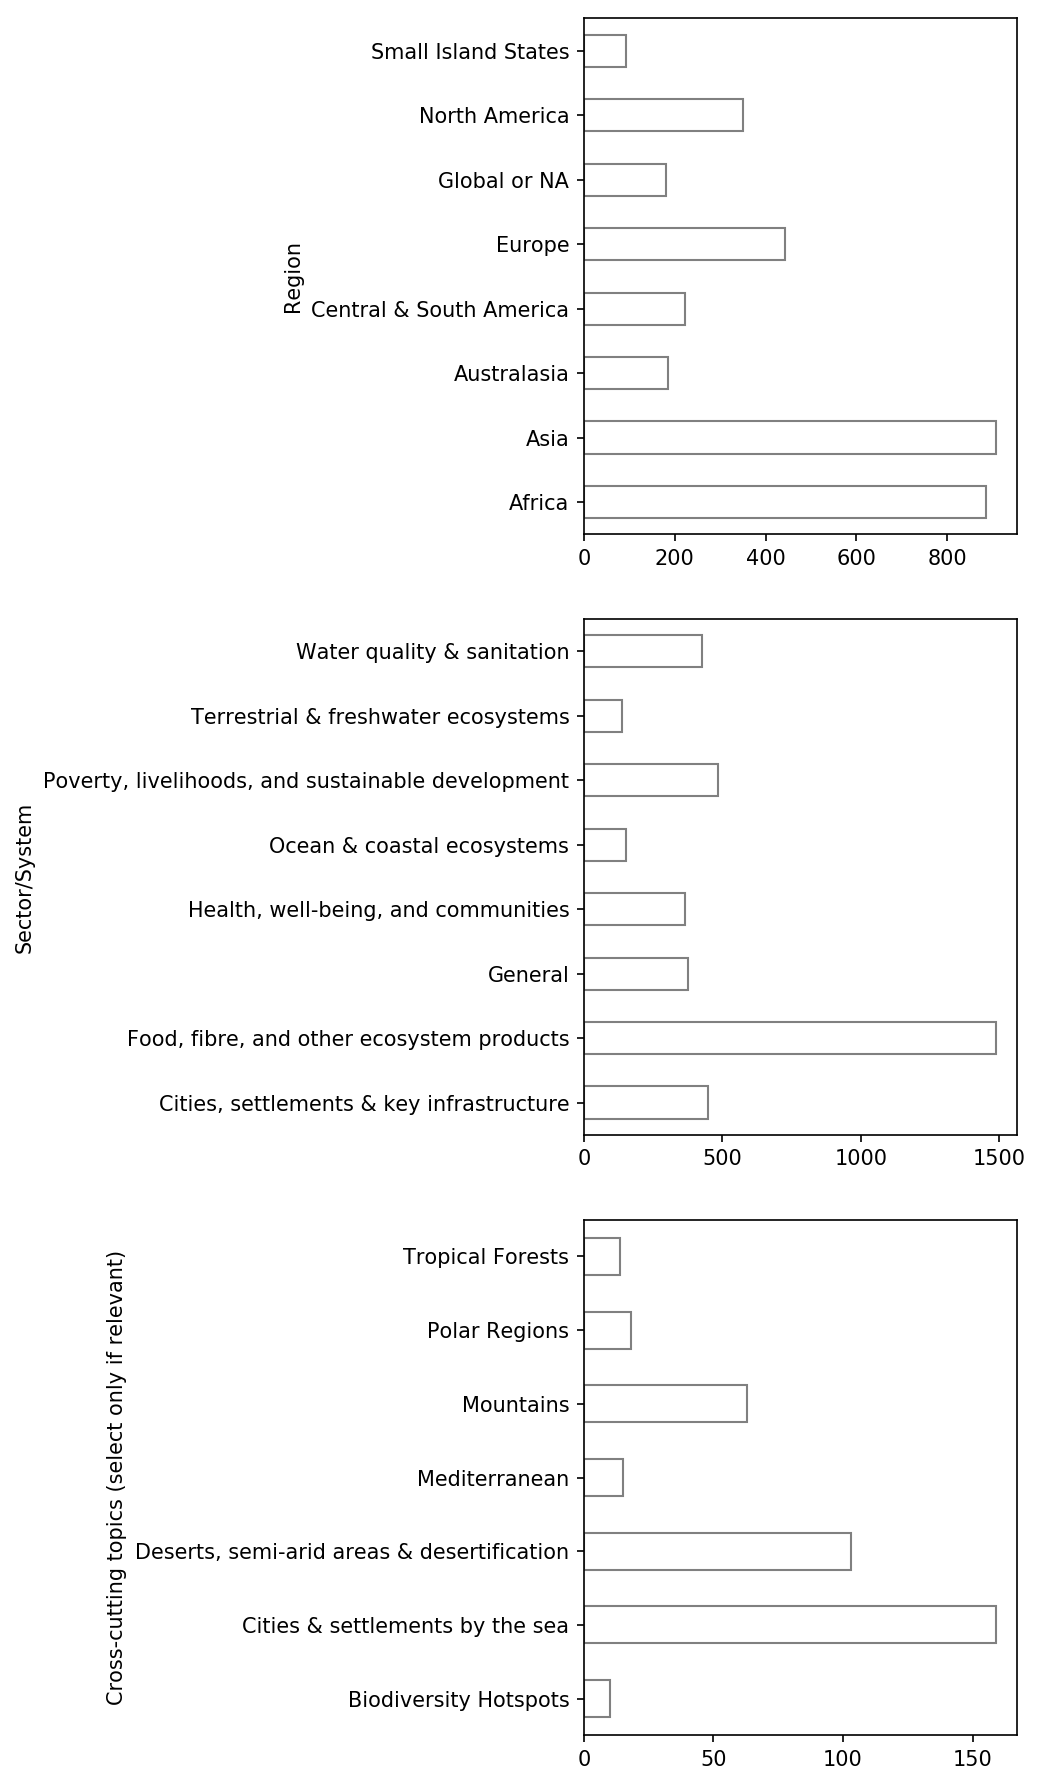

In [12]:
fig = plt.figure(figsize=(7,12),dpi=150)

for i, (name, group) in enumerate(very_long_df.query('variable == "Region"').groupby('value')):    
    print(name)
    print(group.shape[0])
    
for i,x in enumerate(very_long_df['variable'].unique()):
    ax = fig.add_subplot(3,1,i+1)
    print(i)
    very_long_df[very_long_df['variable'] == x].groupby('value').count()['Title'].plot(
        kind="barh", ax=ax,
        color="none",
        linewidth=1,
        edgecolor="grey"
    )
    ax.set_ylabel(x)
    
    
fig.tight_layout()

In [13]:
long_df.head()

long_df['Region'].unique()


array([nan, 'Small Island States', 'Africa', 'Europe', 'Global or NA',
       'Asia', 'Central & South America', 'Australasia', 'North America'],
      dtype=object)

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


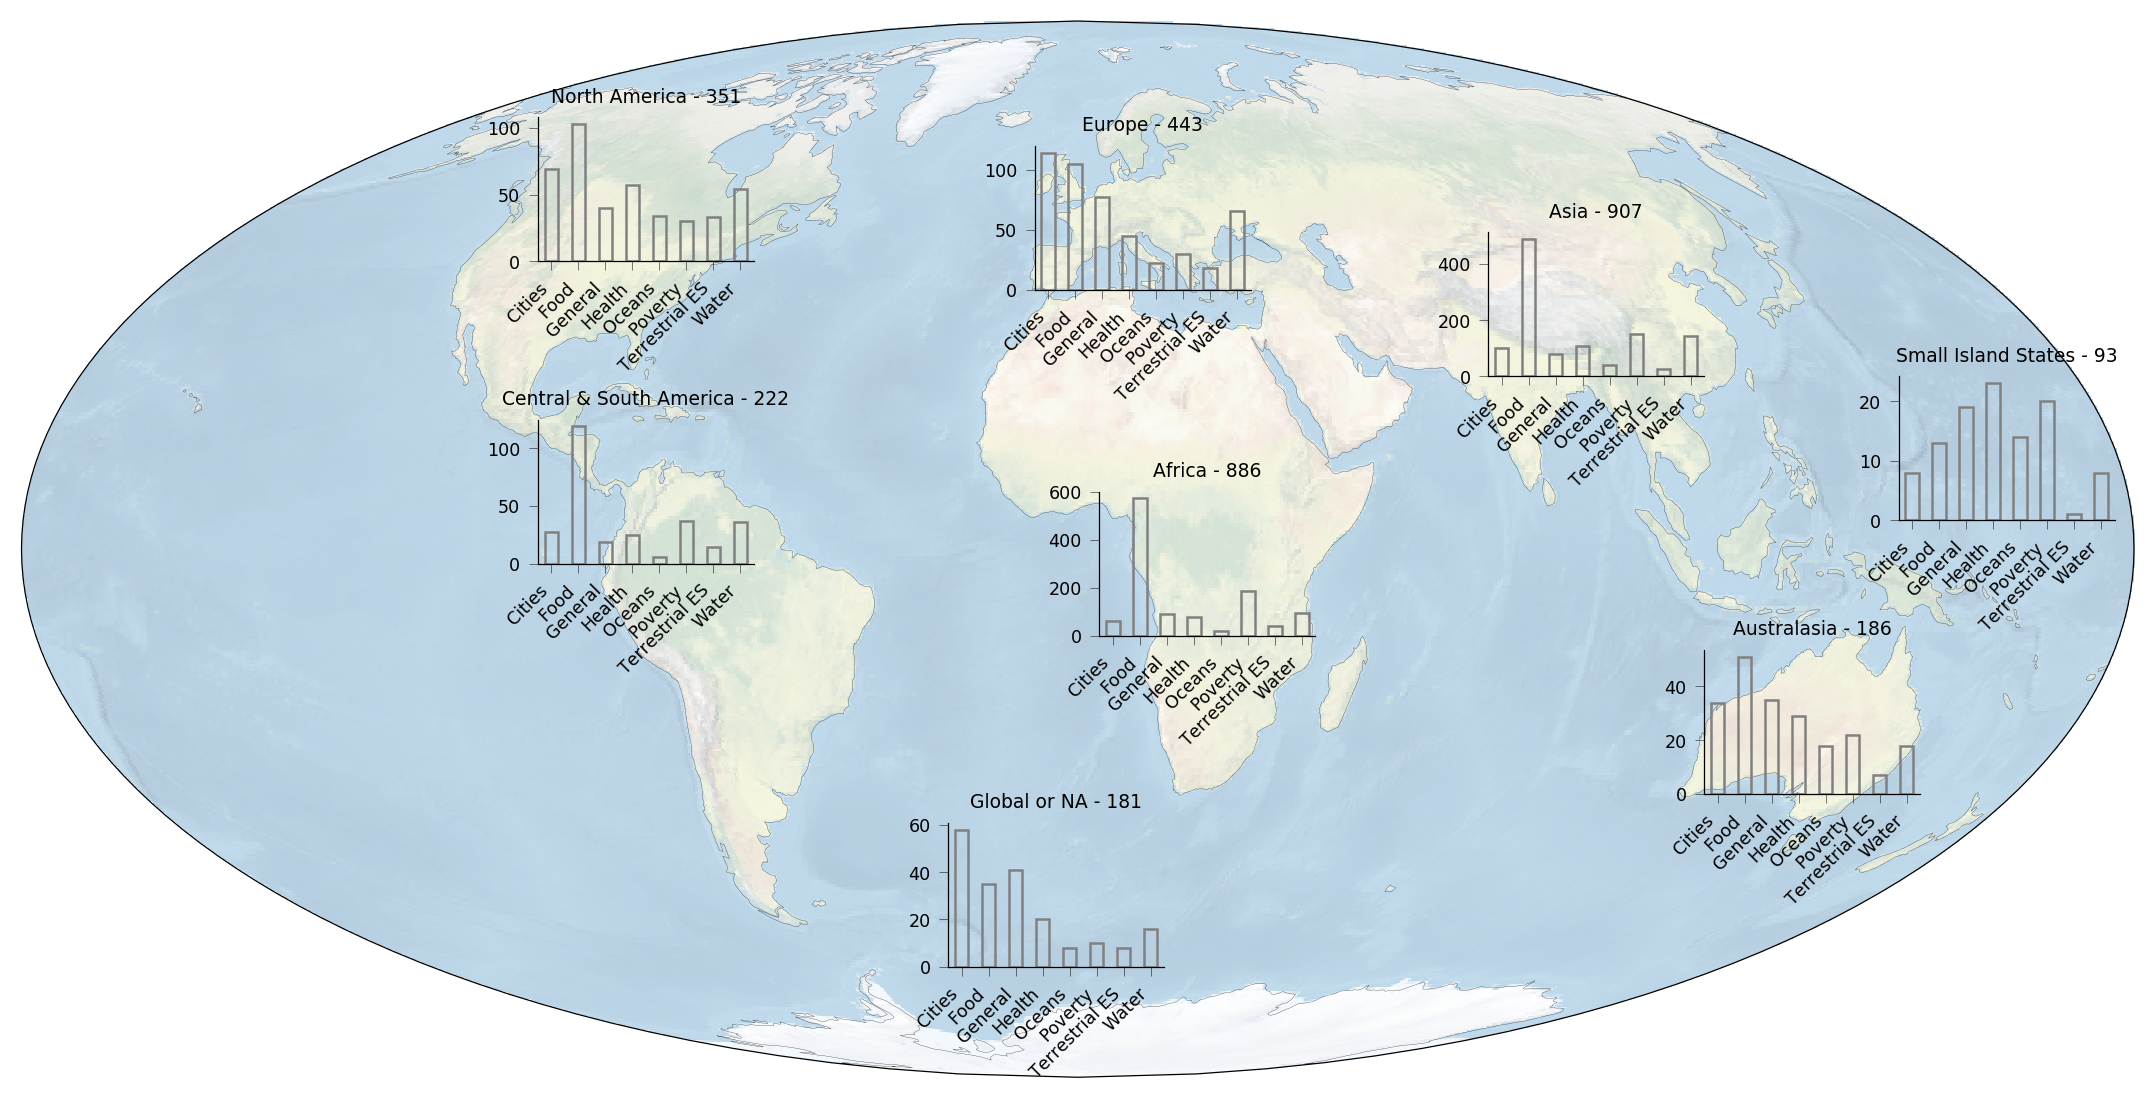

In [14]:
import cartopy.crs as ccrs
from matplotlib.patches import FancyBboxPatch


sector_dict = {
    'Water quality & sanitation': "Water",
    'Terrestrial & freshwater ecosystems': "Terrestrial ES",
    'Cities, settlements & key infrastructure': "Cities",
    'General': "General",
    'Poverty, livelihoods, and sustainable development': "Poverty",
    'Ocean & coastal ecosystems': "Oceans",
    'Food, fibre, and other ecosystem products': "Food",
    'Health, well-being, and communities': "Health"
}

SMALL_SIZE = 7.5
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
TICK_SIZE = 7

rc_big = {
    'font.size': SMALL_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,     # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE,    # fontsize of the x and y labels
    'xtick.labelsize': TICK_SIZE,    # fontsize of the tick labels
    'ytick.labelsize': TICK_SIZE,   # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE,    # legend fontsize
    'figure.titlesize': BIGGER_SIZE, # fontsize of the figure title  
    'axes.linewidth': 0.5,
    'ytick.minor.width': 0.2,
    'ytick.major.width': 0.2,
    'xtick.minor.width': 0.2,
    'xtick.major.width': 0.2
}

regions = [
    {"name": "Europe",    "x": 0.48,    "y": 0.68},
    {"name": "Asia", "x": 0.69, "y": 0.62},
    {"name": "Small Island States", "x": 0.88, "y": 0.52},
    {"name": "Australasia", "x": 0.79, "y": 0.33},
    {"name": "North America", "x": 0.25, "y": 0.7},
    {"name": "Central & South America", "x": 0.25, "y": 0.49},
    {"name": "Africa", "x": 0.51, "y": 0.44},
    #{"name": "Global or NA", "x": 0.04, "y": 0.78},
    {"name": "Global or NA", "x": 0.44, "y": 0.21}
]

with plt.rc_context(rc_big):   
    plt.close()
    fig, ax = plt.subplots(figsize=(12,8), dpi=180)

    ax = plt.axes(projection=ccrs.Mollweide())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.5)

    for r in regions:
        
        p_fancy = FancyBboxPatch((10, 10),
                         10, 10,
                         boxstyle="round,pad=0.1",
                         fc=(1., .8, 1.),
                         ec=(1., 0.5, 1.),zorder=-10)

        ax.add_patch(p_fancy)
        
        a = plt.axes([r["x"],r["y"], .1, .1])
        
        a.set_facecolor("none")
        n = len(long_df[long_df["Region"]==r["name"]]['Our database ID'].unique())
        long_df[long_df["Region"]==r["name"]].groupby(['Sector/System']).count()['Title'].plot(
            kind="bar", ax=a,
            color="none",
            linewidth=1,
            edgecolor="grey"
        )
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.set_title(f'{r["name"]} - {n}')
        a.set_xlabel("")
        ls = [sector_dict[l.get_text()] for l in a.get_xticklabels()]
        a.set_xticklabels(ls, rotation=45, ha="right")
                    
        #a.add_patch(p_fancy)

    ax.set_global()
                    
    fig.tight_layout()
    plt.show()

In [36]:
def plot_geobars(long_df, x, xdict, regions, figsize=(12,8)):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, dpi=180)

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.5)
    ax.set_global()
    
    fig.canvas.draw()

    for r in regions:    
        pdf = long_df[long_df["Region"]==r["name"]][['Our database ID','Region',x]].dropna().drop_duplicates()
        n = len(pdf['Our database ID'].unique())
        if n == 0:
            continue
        ngroups = len(pdf[x].unique())
        
        a = plt.axes([r["x"],r["y"], .1, .07], transform=ccrs.PlateCarree())    
        a.set_facecolor("none")
        
        pdf.groupby([x]).size().plot(
            kind="bar", ax=a,
            color="none",
            linewidth=1,
            edgecolor="grey"
        )
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.set_title(r["name"].replace(" States","\nStates") + f"- {n}")
        a.set_xlabel("")
        ls = [xdict[l.get_text()] for l in a.get_xticklabels()]
        a.set_xticklabels(ls, rotation=45, ha="right")

        fig.canvas.draw_idle()
        ex = a.get_tightbbox(fig.canvas.get_renderer())
        xy = ax.transData.inverted().transform((ex.x0, ex.y0))
        x2y2 = ax.transData.inverted().transform((ex.x1, ex.y1))
        
        if "alpha" in r:
            alpha=r["alpha"]
        else:
            alpha=0.4

        p_fancy = FancyBboxPatch(xy,
             x2y2[0]-xy[0], x2y2[1]-xy[1],
             boxstyle="round,pad=3",
             alpha=alpha,
             fc="white",
             ec="grey"
        )

        ax.add_patch(p_fancy)
    plt.show()   
    


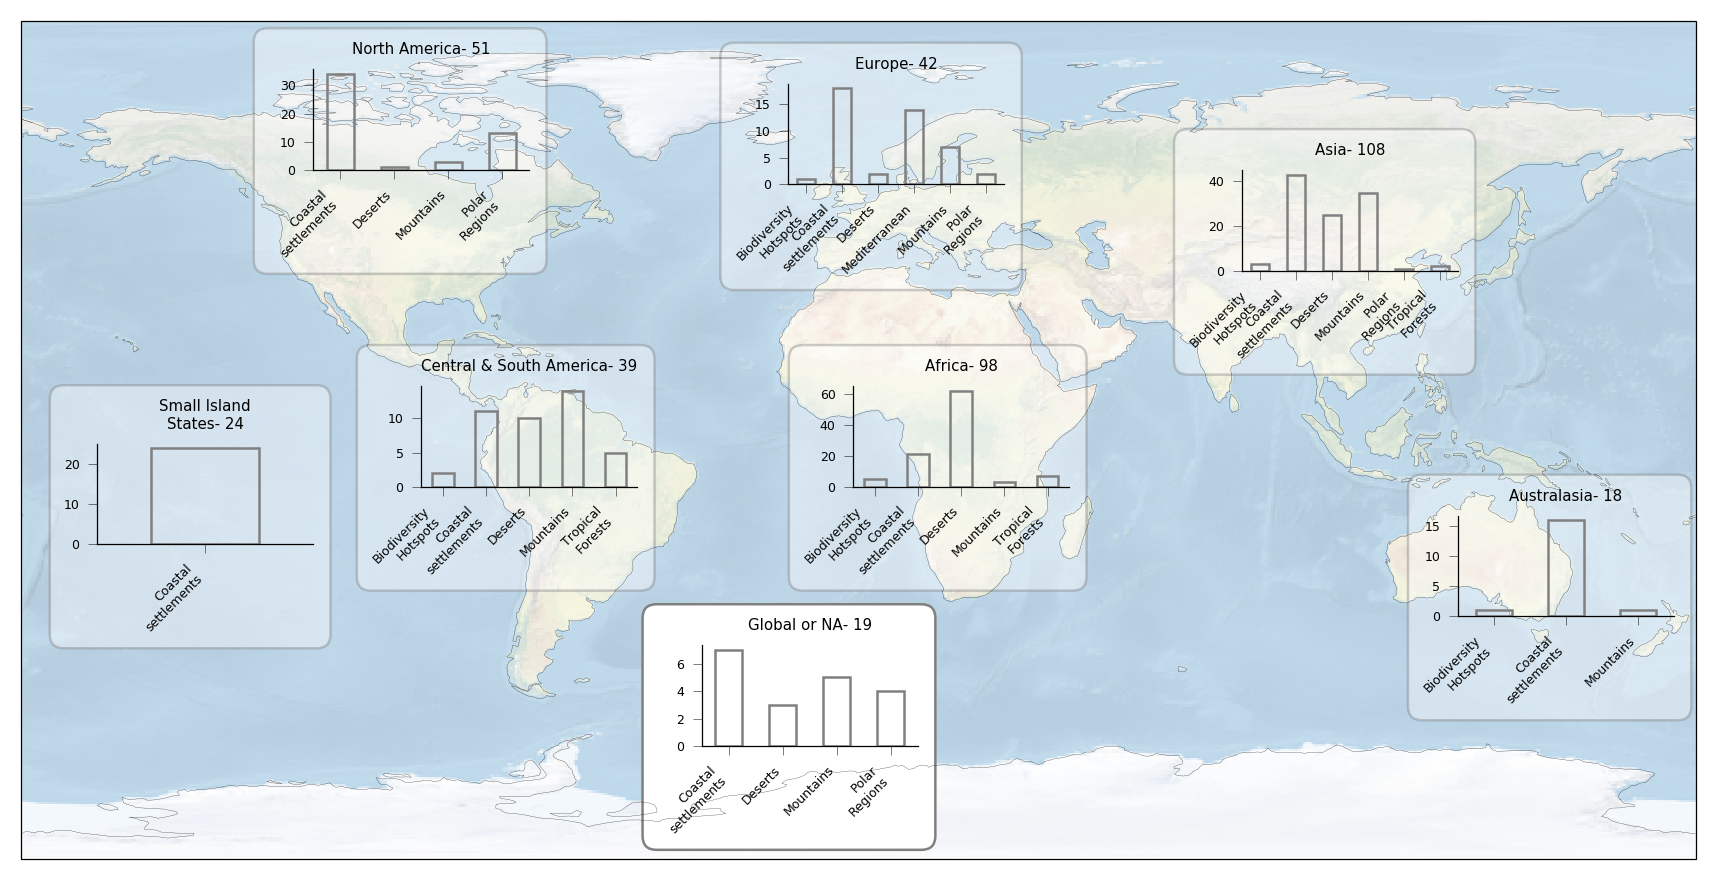

In [16]:
crosscut_dict = {
    'Cities & settlements by the sea': "Coastal\nsettlements",
    'Polar Regions': "Polar\nRegions",
    'Deserts, semi-arid areas & desertification': "Deserts",
    'Mountains': "Mountains",
    'Tropical Forests': "Tropical\nForests",
    'Mediterranean': "Mediterranean", 
    'Biodiversity Hotspots': "Biodiversity\nHotspots"
}

SMALL_SIZE = 6
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
TICK_SIZE = 5

rc_big = {
    'font.size': SMALL_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,     # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE,    # fontsize of the x and y labels
    'xtick.labelsize': TICK_SIZE,    # fontsize of the tick labels
    'ytick.labelsize': TICK_SIZE,   # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE,    # legend fontsize
    'figure.titlesize': BIGGER_SIZE, # fontsize of the figure title  
    'axes.linewidth': 0.5,
    'ytick.minor.width': 0.2,
    'ytick.major.width': 0.2,
    'xtick.minor.width': 0.2,
    'xtick.major.width': 0.2
}

regions = [
    {"name": "Europe",    "x": 0.48,    "y": 0.68},
    {"name": "Asia", "x": 0.69, "y": 0.62},
    {"name": "Small Island States", "x": 0.16, "y": 0.43},
    {"name": "Australasia", "x": 0.79, "y": 0.38},
    {"name": "North America", "x": 0.26, "y": 0.69},
    {"name": "Central & South America", "x": 0.31, "y": 0.47},
    {"name": "Africa", "x": 0.51, "y": 0.47},
    {"name": "Global or NA", "x": 0.44, "y": 0.29, "alpha":1}
]

with plt.rc_context(rc_big):   
    plot_geobars(long_df, 'Cross-cutting topics (select only if relevant)', crosscut_dict, regions)

{'Water quality & sanitation': 'Water', 'Terrestrial & freshwater ecosystems': 'Terrestrial ES', 'Cities, settlements & key infrastructure': 'Cities', 'General': 'General', 'Poverty, livelihoods, and sustainable development': 'Poverty', 'Ocean & coastal ecosystems': 'Oceans', 'Food, fibre, and other ecosystem products': 'Food', 'Health, well-being, and communities': 'Health'}


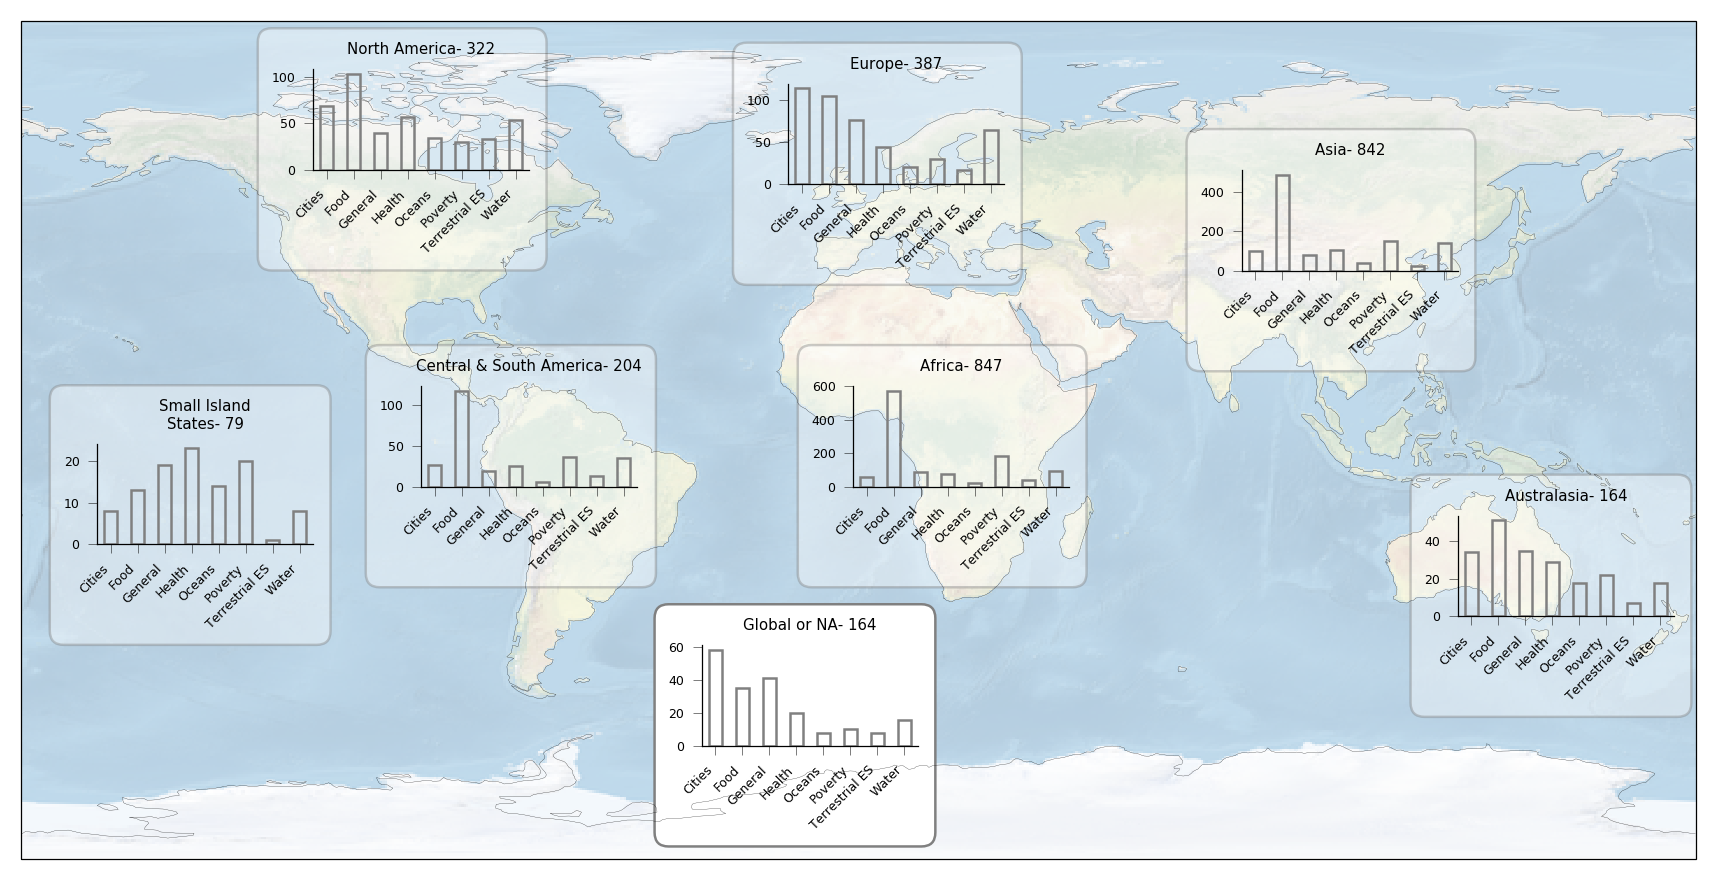

In [17]:
regions = [
    {"name": "Europe",    "x": 0.48,    "y": 0.68},
    {"name": "Asia", "x": 0.69, "y": 0.62},
    {"name": "Small Island States", "x": 0.16, "y": 0.43},
    {"name": "Australasia", "x": 0.79, "y": 0.38},
    {"name": "North America", "x": 0.26, "y": 0.69},
    {"name": "Central & South America", "x": 0.31, "y": 0.47},
    {"name": "Africa", "x": 0.51, "y": 0.47},
    #{"name": "Global or NA", "x": 0.04, "y": 0.78},
    {"name": "Global or NA", "x": 0.44, "y": 0.29, "alpha":1}
]

x = 'Sector/System'
xdict = sector_dict
print(xdict)

with plt.rc_context(rc_big):   
    plot_geobars(long_df, 'Sector/System', sector_dict, regions)

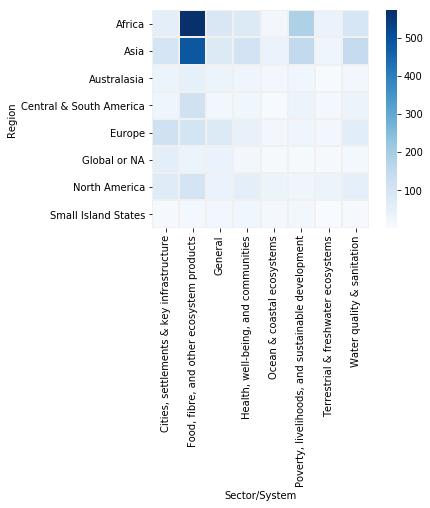

In [18]:
import seaborn as sns
def do_heatmap(df, x, y):
    pdf = df[['Our database ID',x,y]].dropna().drop_duplicates().reset_index(drop=True)
    pdf = pdf.groupby([x,y]).size().unstack()
    pdf.head()
   
    ax = sns.heatmap(
        pdf,
        cmap="Blues",
        square=True,
        linecolor="#F0F0F0",
        linewidths=1
    )
    

do_heatmap(long_df, 'Region', 'Sector/System')

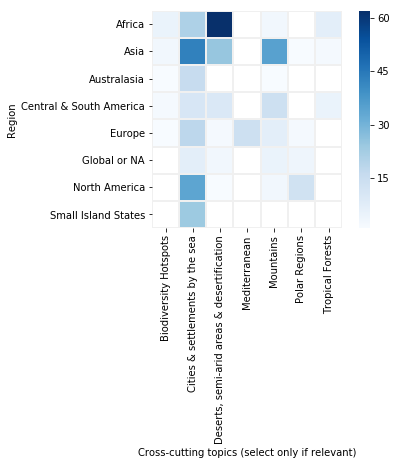

In [19]:
do_heatmap(long_df, 'Region', 'Cross-cutting topics (select only if relevant)')

In [21]:
print(df.columns)
print(df.shape)
df.head()

Index(['Our database ID', 'Title', 'Abstract', 'Publication Year', 'DOI',
       'Africa', 'Asia', 'Australasia', 'Central & South America',
       'North America', 'Europe', 'Small Island States', 'Global or NA',
       'Terrestrial & freshwater ecosystems', 'Ocean & coastal ecosystems',
       'Water quality & sanitation',
       'Food, fibre, and other ecosystem products',
       'Cities, settlements & key infrastructure',
       'Health, well-being, and communities',
       'Poverty, livelihoods, and sustainable development', 'General',
       'Polar Regions', 'Mountains', 'Tropical Forests',
       'Cities & settlements by the sea', 'Biodiversity Hotspots',
       'Mediterranean', 'Deserts, semi-arid areas & desertification',
       'DB2 Inclusion'],
      dtype='object')
(3252, 29)


Our database ID                                              Title  \
0          2333830  Farming the Floodplain: Ecological and Agricul...   
1          2279660  Participatory action research (PAR) as an entr...   
2          2461130  Climate adaptation practices in building const...   
3           688401  Climate-smart soil water and nutrient manageme...   
4          1295127  Evaluating knowledge integration and co-produc...   

                                            Abstract  Publication Year  \
0  In New England (United States) climate change ...            2017.0   
1  Emerging trends of a changing and increasingly...            2013.0   
2  Climate change and increased floods events are...            2018.0   
3  There is an increasing need for West African S...            2014.0   
4  Although knowledge integration and co-producti...            2018.0   

                            DOI  Africa   Asia  Australasia  \
0    10.1525/cse.2017.sc.512407   False  False        False   
1  10.1016/j.envdev.2012.11.001   False  False        False   
2                          None    True  False        False   
3        10.1186/2048-7010-3-16    True  False        False   
4     10.1007/s11625-018-0553-6    True  False        False   

   Central & South America  North America      ...        \
0                    False           True      ...         
1                    False           True      ...         
2                    False          False      ...         
3                    False          False      ...         
4                    False          False      ...         

   Poverty, livelihoods, and sustainable development  General  Polar Regions  \
0                                              False    False          False   
1                                              False    False          False   
2                                              False    False          False   
3                                              False    False          False   
4                                              False    False          False   

   Mountains  Tropical Forests  Cities & settlements by the sea  \
0      False             False                            False   
1      False             False                            False   
2      False             False                            False   
3      False             False                            False   
4      False             False                            False   

   Biodiversity Hotspots  Mediterranean  \
0                  False          False   
1                  False          False   
2                   True          False   
3                  False          False   
4                  False          False   

   Deserts, semi-arid areas & desertification  DB2 Inclusion  
0                                       False           True  
1                                       False          False  
2                                       False           True  
3                                       False          False  
4                                       False          False  

[5 rows x 29 columns]

In [39]:
dfid_docs = df[
    (df['DB2 Inclusion']==True) 
    & (df["Global or NA"]==False) 
    & (df['North America']==False)
    & (df['Europe']==False)
    & (df['Australasia']==False)
    & (df['Health, well-being, and communities']==True)
]
print(dfid_docs.shape)
dfid_docs.head()

(152, 29)


Our database ID                                              Title  \
7             679807  Forest adjacent households' voices on their pe...   
53            223202  Use of traditional medicines to cope with clim...   
65            214375  Climate adaptation at what scale? Multi-level ...   
95            768847  Conservation agriculture and gendered liveliho...   
115           551641  Prospects and challenges of local community ad...   

                                              Abstract  Publication Year  \
7    Climate change is a global and local challenge...            2016.0   
53   Background: This study aims to explore the use...            2014.0   
65   This paper utilizes a multi-level governance f...            2016.0   
95   Smallholder farmers in Rattanakmondol District...            2017.0   
115  In response to global climatic change and vari...            2015.0   

                              DOI  Africa   Asia  Australasia  \
7       10.1186/s40064-016-2484-y    True  False        False   
53       10.1186/1471-2458-14-202   False   True        False   
65      10.1007/s11069-015-1875-7    True  False        False   
95      10.1007/s10460-016-9718-z   False   True        False   
115  10.1007/978-3-642-38670-1_85    True  False        False   

     Central & South America  North America      ...        \
7                      False          False      ...         
53                     False          False      ...         
65                     False          False      ...         
95                     False          False      ...         
115                    False          False      ...         

     Poverty, livelihoods, and sustainable development  General  \
7                                                False    False   
53                                               False    False   
65                                                True    False   
95                                                True    False   
115                                              False    False   

     Polar Regions  Mountains  Tropical Forests  \
7            False      False              True   
53           False      False             False   
65           False      False             False   
95           False      False             False   
115          False      False             False   

     Cities & settlements by the sea  Biodiversity Hotspots  Mediterranean  \
7                              False                  False          False   
53                             False                  False          False   
65                             False                  False          False   
95                             False                  False          False   
115                            False                  False          False   

     Deserts, semi-arid areas & desertification  DB2 Inclusion  
7                                         False           True  
53                                        False           True  
65                                        False           True  
95                                        False           True  
115                                       False           True  

[5 rows x 29 columns]

In [40]:
dfid_long = long_df[long_df['Our database ID'].isin(dfid_docs['Our database ID'])]
dfid_long.head()

Our database ID                                              Title  \
531             14383  Gender differences in farmers' responses to cl...   
530             14383  Gender differences in farmers' responses to cl...   
2942            26505  Enabling environments? Insights into the polic...   
3063            29146  Rural families' interpretations of experiencin...   
2871            40076  Micro hydropower: an alternative for climate c...   

                                               Abstract  Publication Year  \
531   This study examines the gender differences in ...            2015.0   
530   This study examines the gender differences in ...            2015.0   
2942  Changes in climatic conditions and increases i...            2013.0   
3063  Natural disasters affect populations in variou...            2017.0   
2871  In this essay, we explore the contribution of ...            2017.0   

                                  DOI  DB2 Inclusion                   Region  \
531   10.1016/j.scitotenv.2015.07.027           True                     Asia   
530   10.1016/j.scitotenv.2015.07.027           True                     Asia   
2942     10.1080/17565529.2013.833077           True                     Asia   
3063        10.1590/0102-311X00161515           True  Central & South America   
2871        10.1007/s10584-016-1865-0           True  Central & South America   

                                  Sector/System  \
531   Food, fibre, and other ecosystem products   
530         Health, well-being, and communities   
2942        Health, well-being, and communities   
3063        Health, well-being, and communities   
2871        Health, well-being, and communities   

     Cross-cutting topics (select only if relevant)  
531                                             NaN  
530                                             NaN  
2942                                            NaN  
3063                                            NaN  
2871                Cities & settlements by the sea

In [41]:
dfid_very_long = very_long_df[very_long_df['Our database ID'].isin(dfid_docs['Our database ID'])]
dfid_very_long.head()

Our database ID                                              Title  \
20            679807  Forest adjacent households' voices on their pe...   
21            679807  Forest adjacent households' voices on their pe...   
22            679807  Forest adjacent households' voices on their pe...   
23            679807  Forest adjacent households' voices on their pe...   
122           223202  Use of traditional medicines to cope with clim...   

                                              Abstract  Publication Year  \
20   Climate change is a global and local challenge...            2016.0   
21   Climate change is a global and local challenge...            2016.0   
22   Climate change is a global and local challenge...            2016.0   
23   Climate change is a global and local challenge...            2016.0   
122  Background: This study aims to explore the use...            2014.0   

                           DOI  DB2 Inclusion  \
20   10.1186/s40064-016-2484-y           True   
21   10.1186/s40064-016-2484-y           True   
22   10.1186/s40064-016-2484-y           True   
23   10.1186/s40064-016-2484-y           True   
122   10.1186/1471-2458-14-202           True   

                                           variable  \
20   Cross-cutting topics (select only if relevant)   
21                                           Region   
22                                    Sector/System   
23                                    Sector/System   
122                                          Region   

                                         value  
20                            Tropical Forests  
21                                      Africa  
22         Health, well-being, and communities  
23   Food, fibre, and other ecosystem products  
122                                       Asia

0
1
2


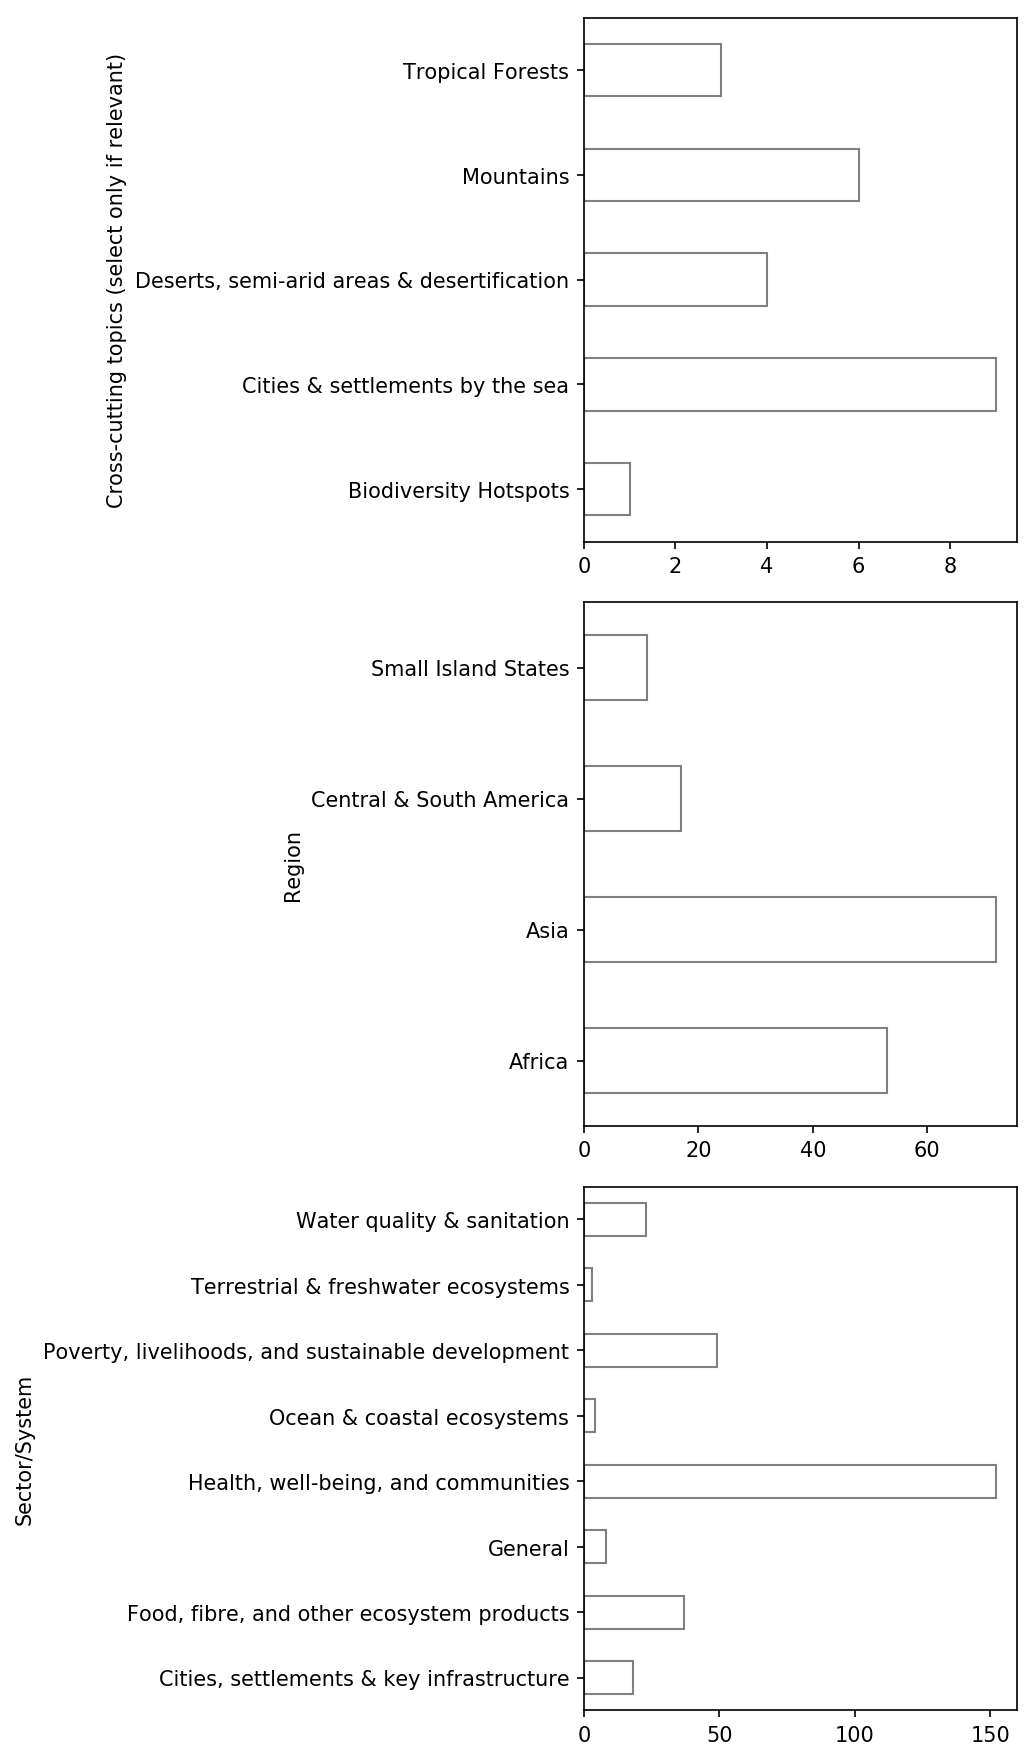

In [42]:
fig = plt.figure(figsize=(7,12),dpi=150)
    
for i,x in enumerate(dfid_very_long['variable'].unique()):
    ax = fig.add_subplot(3,1,i+1)
    print(i)
    dfid_very_long[dfid_very_long['variable'] == x].groupby('value').count()['Title'].plot(
        kind="barh", ax=ax,
        color="none",
        linewidth=1,
        edgecolor="grey"
    )
    ax.set_ylabel(x)
    
    
fig.tight_layout()

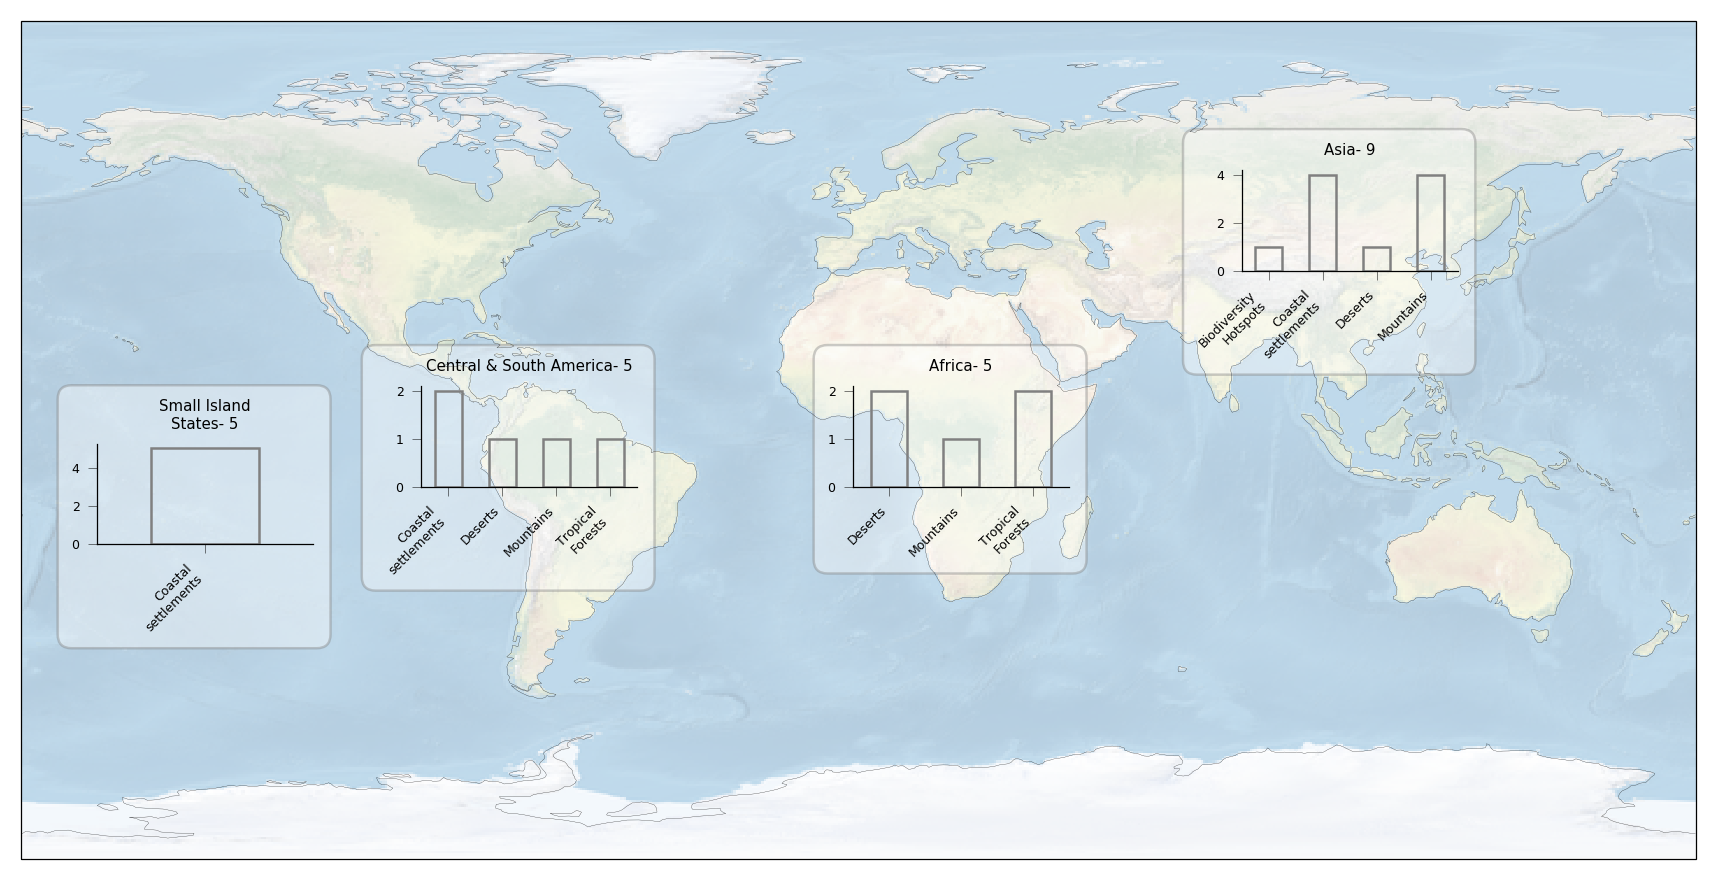

In [43]:
with plt.rc_context(rc_big):   
    plot_geobars(dfid_long, 'Cross-cutting topics (select only if relevant)', crosscut_dict, regions)

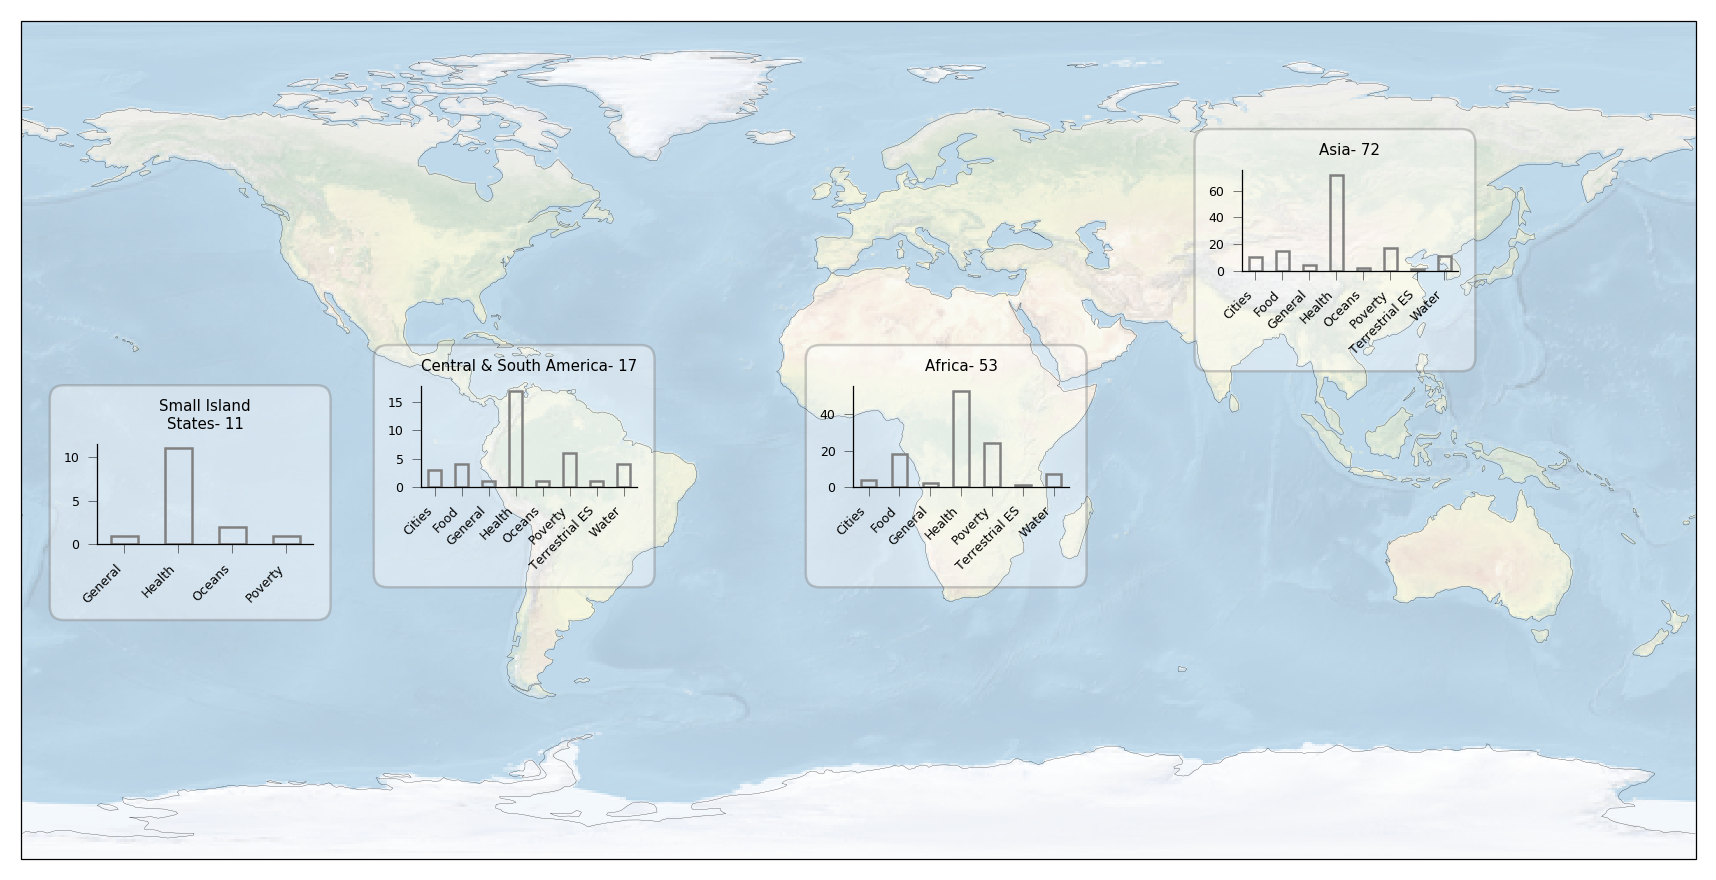

In [44]:
with plt.rc_context(rc_big):   
    plot_geobars(dfid_long, 'Sector/System', sector_dict, regions)

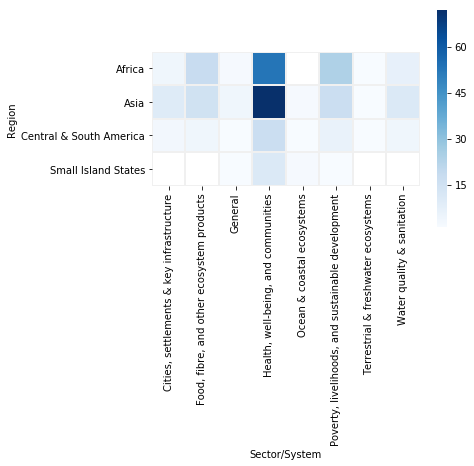

In [46]:
do_heatmap(dfid_long, 'Region', 'Sector/System')

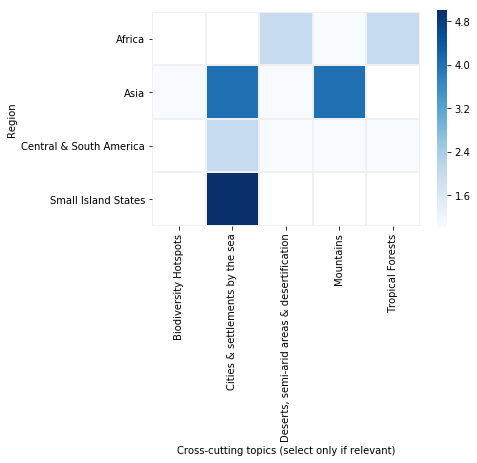

In [47]:
do_heatmap(dfid_long, 'Region', 'Cross-cutting topics (select only if relevant)')